# Import libraries

In [ ]:
import numpy as np
from collections import Counter
import struct
from array import array
import os
import random
import matplotlib.pyplot as plt

# MNIST

In [ ]:
# Set file paths based on added MNIST Datasets
TRAINING_IMAGES_FILEPATH = 'train-images.idx3-ubyte'
TRAINING_LABELS_FILEPATH = 'train-labels.idx1-ubyte'
TEST_IMAGES_FILEPATH = 't10k-images.idx3-ubyte'
TEST_LABELS_FILEPATH = 't10k-labels.idx1-ubyte'

In [ ]:
# MNIST Data Loader Class
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        img_train, lable_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        img_test, lable_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (img_train, lable_train), (img_test, lable_test)

In [ ]:
# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(30, 20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if title_text != '':
            plt.title(title_text, fontsize=15);
        index += 1
    plt.show()

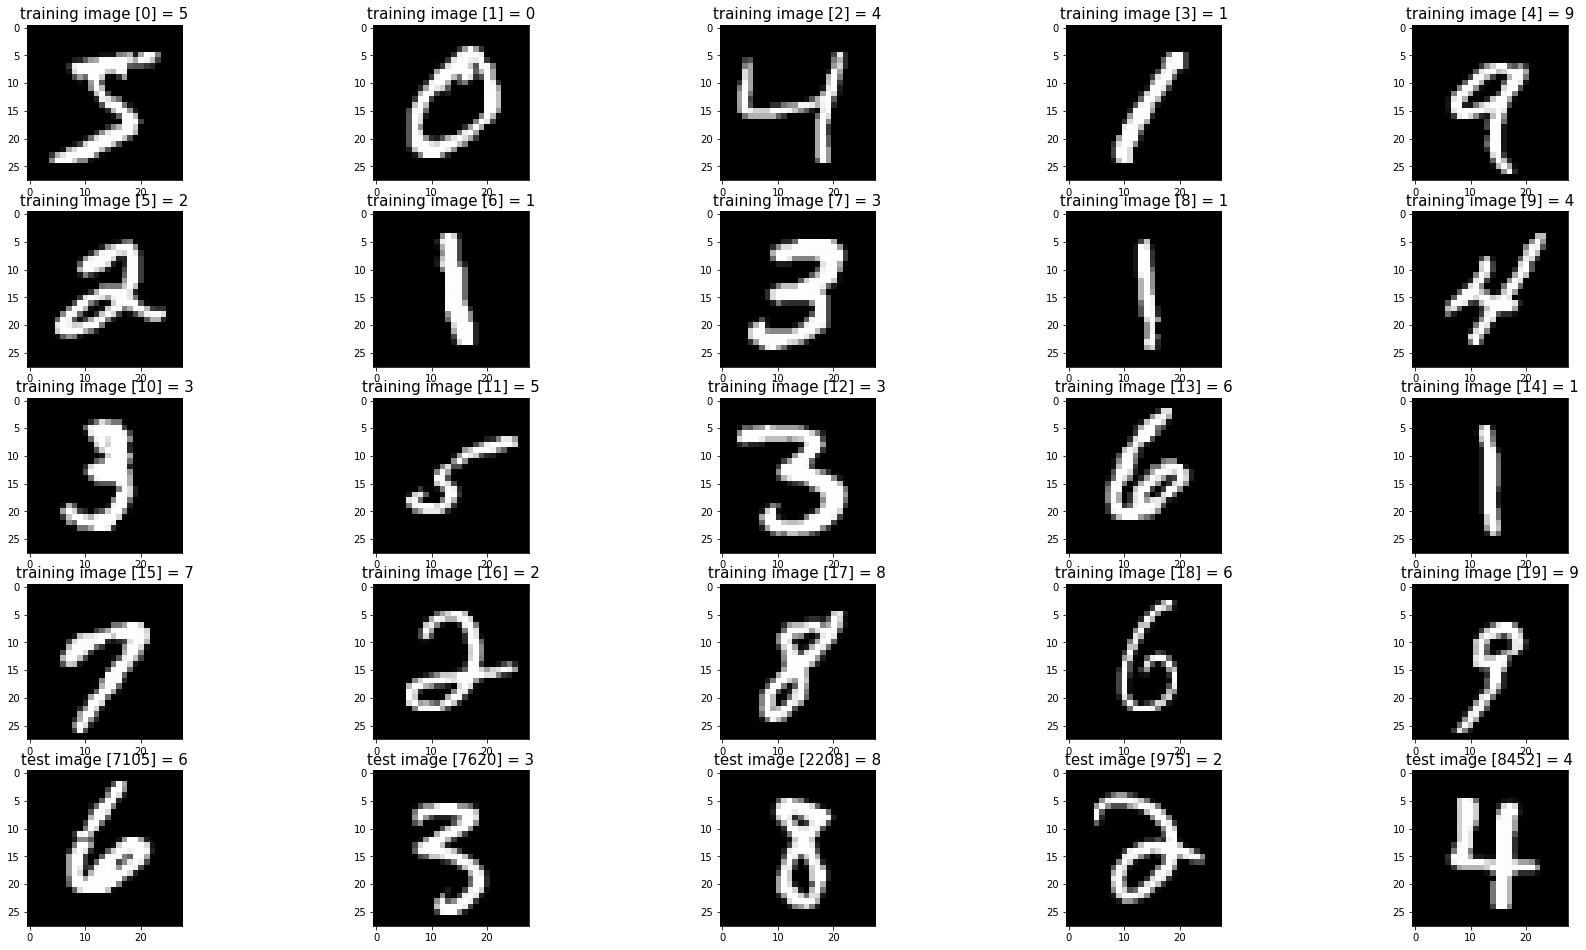

In [ ]:
# Load MINST dataset
mnist_dataloader = MnistDataloader(TRAINING_IMAGES_FILEPATH, 
                                   TRAINING_LABELS_FILEPATH,
                                   TEST_IMAGES_FILEPATH,
                                   TEST_LABELS_FILEPATH)
(img_train, lable_train), (img_test, lable_test) = mnist_dataloader.load_data()

# Show some random training and test images
images_2_show = []
titles_2_show = []
for r in range(0,20):
    #r = random.randint(1, 60000)
    images_2_show.append(img_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(lable_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(img_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(lable_test[r]))

show_images(images_2_show, titles_2_show)

# K-Means

In [ ]:
class k_means():
    BIT_SIZE = 253
    K = 10
    MAX_INT = 9223372036854775807
    BIT_AVG_THRESHOLD = 1/6
    MAX_REPS = 200
    REDUNDENT_NORM_CHANGE = 1/1000

    def __init__(self):
        '''
        @:param clusters (list): list of clusters for each number
        @:param group_rep (list): list of group representatives
        '''
        (self.img_train, self.img_test) = (None, None)
        self.clusters =[[] for _ in range(self.K)]
        self.load_data()
        self.clusters_rep = self._init_cluster_centers_randomly()
        self.cluster_labels = [-1] * 10
        self.model_train_counter = 0

    def _init_cluster_centers_randomly(self):
        ls = []
        for _ in range(self.K):
            ls.append(self._create_random_img())
        return ls

    def _init_cluster_centers_manually(self):
        ls = [1,6,189,149,336,219,13,15,265,362]
        ls_slim = [156,124,190,245,338,145,274,307,114,153]
        return [self.img_train[index].img for index in ls_slim]

    def _create_random_img(self):
        mat = [np.random.randint(2, size=28) for _ in range(28)]
        return np.array(mat)

    def run(self):
        self._train_model()
        self._test_model()

    def _test_model(self):
        self.clusters = [[] for _ in range(self.K)]
        self._divide_imgs_to_clusters(self.img_test)
        self._print_result()

    def _print_result(self):
        print("The model was trained for %s times" %self.model_train_counter)
        success_count_lst = self._measure_success()
        labels_to_print = []
        for i in range(self.K):
            sucsess_rate = -1
            if len(self.clusters[i])!=0:
                sucsess_rate = success_count_lst[i] / len(self.clusters[i])
            labels_to_print.append("Cluster: %s | Success rate: %s" %(self.cluster_labels[i], format(sucsess_rate, ".3f")))
        for st in labels_to_print:
            print(st)
        show_images(self.clusters_rep,labels_to_print)

    def _measure_success(self):
        sucsess_count = [0] * self.K
        for i in range(self.K):
            for img in self.clusters[i]:
                if img.label == self.cluster_labels[i]:
                    sucsess_count[i] += 1
        return sucsess_count

    def _divide_imgs_to_clusters(self, img_lst):
        for img in img_lst:
            index = self._get_closest_cluster_index_using_diff(img)
            self.clusters[index].append(img)

    def _train_model(self):
        while -1 in self.cluster_labels and self.model_train_counter < self.MAX_REPS:
            self._divide_imgs_to_clusters(self.img_train)
            self.clusters_rep = [self._get_cluster_new_rep(i) for i in range(self.K)]
            self.model_train_counter += 1

        for index in range(self.K):
            if self.cluster_labels[index] == -1:
                self._fix_cluster_label_to_most_common(index)

    def _get_cluster_new_rep(self,index):
        if self.cluster_labels[index]!=-1:
            return self.clusters_rep[index]
        else:
            rep = self._get_cluster_avg_rep(index)
            if np.linalg.norm(rep) - np.linalg.norm(self.clusters_rep[index])<self.REDUNDENT_NORM_CHANGE:
                self._fix_cluster_label_to_most_common(index)
            return rep

    def _get_cluster_avg_rep(self,index):
        cluster_sum = np.zeros((28, 28))
        for img in self.clusters[index]:
            cluster_sum += img.img
        if len(self.clusters[index]) > 0:
            return cluster_sum/(len(self.clusters[index]))
        return cluster_sum

    def _fix_cluster_label_to_most_common(self, index):
        lst = [item.label for item in self.clusters[index]]
        mc = self._most_common(lst)
        self.cluster_labels[index] = mc

    def _most_common(self, lst):
        if len(lst) == 0:
            return -1
        data = Counter(lst)
        return data.most_common(1)[0][0]

    def _get_closest_cluster_index(self, img):
        i = 0
        max_similarity_index = 0
        max_similarity = -1
        for rep in self.clusters_rep:
            curr_similarity = self._similarity(rep, img.img)
            if curr_similarity > max_similarity:
                max_similarity_index = i
                max_similarity = curr_similarity
            i += 1
        return max_similarity_index

    def _get_closest_cluster_index_using_diff(self, img):
        i = 0
        min_diff_index = 0
        min_diff = self.MAX_INT
        for rep in self.clusters_rep:
            curr_diff = np.linalg.norm(rep - img.img)
            if curr_diff < min_diff:
                min_diff_index = i
                min_diff = curr_diff
            i += 1
        return min_diff_index

    def _diff(self, img1, img2):
        '''
        :param img1:
        :param img2:
        :return (int): a number thar represent how "close" img1 and img2 are
        '''
        sum_diff = 0
        for i in list(range(len(img1))):
            for j in range(len(img1[i])):
                img1_pixel = self._get_pixel_value(img1[i][j])
                img2_pixel = self._get_pixel_value(img2[i][j])
                sum_diff += abs(img1_pixel - img2_pixel)
        return sum_diff

    def _get_pixel_value(self, pix):
        if pix < 1:
            return 0
        return 1

    def _similarity(self, img1, img2):
        '''
        :param img1:
        :param img2:
        :return(int): a number thar represent how "close" img1 and img2 are
        '''
        sum = 0
        for i in list(range(len(img1))):
            for j in range(len(img1[i])):
                img1_pixel = int((img1[i][j]))
                img2_pixel = int((img2[i][j]))
                sum += abs(img1_pixel * img2_pixel)
        return sum

    def load_data(self):
        mnist_dataLoader = MnistDataloader(TRAINING_IMAGES_FILEPATH,
                                           TRAINING_LABELS_FILEPATH,
                                           TEST_IMAGES_FILEPATH, 
                                           TEST_LABELS_FILEPATH)
        (img_train, label_train), (img_test, label_test) = mnist_dataLoader.load_data()
        self.img_train = [Image(tup[0],tup[1]) for tup in list(zip(img_train, label_train))][:30000]
        self.img_test = [Image(tup[0],tup[1]) for tup in list(zip(img_test, label_test))]

In [ ]:
class Image():
    def __init__(self,img,label):
        self.img = (np.array(img)/k_means.BIT_SIZE)
        self.label = label

The model was trained for 45 times
Cluster: 1 | Success rate: 0.003
Cluster: 8 | Success rate: 0.167
Cluster: 7 | Success rate: 0.165
Cluster: 6 | Success rate: 0.329
Cluster: 7 | Success rate: 0.667
Cluster: 1 | Success rate: 0.623
Cluster: 0 | Success rate: 0.893
Cluster: 4 | Success rate: 0.000
Cluster: 0 | Success rate: 0.773
Cluster: 0 | Success rate: 0.430


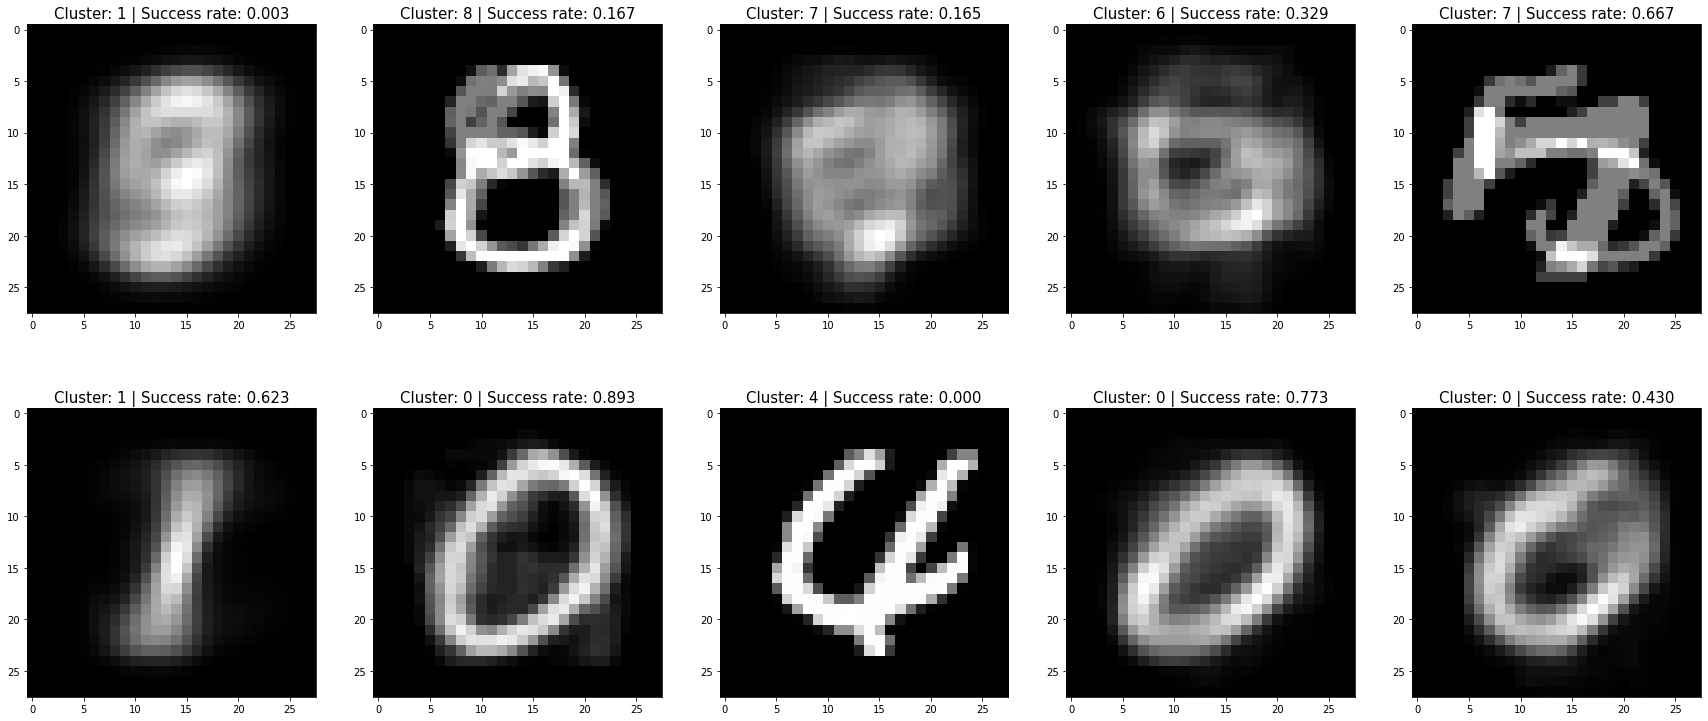

In [ ]:
k_means_algorithm = k_means()
k_means_algorithm.run()